In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Import the original classes from your losses.py file
from src.metrics.losses import ClassificationKernelLoss, ClassificationMixedLoss,ECEKDEMixedLoss, MMCEMixedLoss
import pandas as pd
from sklearn.model_selection import train_test_split # Import the missing function


In [ ]:
# Define a simple model
class LogisticRegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 2)
        self.output_size = 2  # Required for ClassificationKernelLoss

    def forward(self, x):
        return self.linear(x)

# Training function
def train_model(model, loss_fn, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        for batch in train_loader:
            inputs, targets = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(inputs, targets, outputs)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


# Home Ownership

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/afarahi/Scientific-Machine-Learning/main/AHS_2019_Cleaned.CSV').drop('Unnamed: 0', axis=1)
df.head()

,BLACK,HHSEX,METRO,HHGRAD,HHMAR,HHCITSHP,HHAGE,NUMPEOPLE,HINCP,DIVISION,OWNER
0,0.0,1,1.0,44,1,1,52,3,5.409933,5,1.0
1,0.0,2,1.0,44,4,1,80,2,5.303196,1,1.0
2,0.0,1,1.0,47,1,1,72,2,4.825426,7,1.0
3,1.0,2,1.0,40,6,1,60,1,4.544068,4,0.0
4,0.0,2,1.0,39,3,1,80,2,4.309630,4,0.0


In [ ]:
df.shape

(48660, 11)

In [ ]:
# convert category dtype to numeric
df['OWNER']=df['OWNER'].astype('int64')

df['OWNER']=df['OWNER'].astype('category')
features = ['BLACK', 'HHSEX', 'METRO', 'HHGRAD', 'HHMAR', 'HHCITSHP', 'HHAGE', 'NUMPEOPLE', 'HINCP', 'DIVISION']
dependent_var = ['OWNER']

X = df[features]
y = df[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1090)
condition_test=X_test.index

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)

X_test_tensor = torch.FloatTensor(X_test_scaled)


y_train_tensor = torch.tensor(y_train['OWNER'].values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test['OWNER'].values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# Train with standard cross-entropy loss
model_ce = LogisticRegressionNN(input_dim=10)
optimizer_ce = optim.Adam(model_ce.parameters(), lr=0.01)
train_model(model_ce, lambda x, y, z: nn.CrossEntropyLoss()(z, y), optimizer_ce)


Epoch 10, Loss: 0.4243
Epoch 20, Loss: 0.6157
Epoch 30, Loss: 0.5062
Epoch 40, Loss: 0.5681
Epoch 50, Loss: 0.6020
Epoch 60, Loss: 0.4791
Epoch 70, Loss: 0.3538
Epoch 80, Loss: 0.5681
Epoch 90, Loss: 0.3668
Epoch 100, Loss: 0.5784


In [ ]:
# Train with mixed loss (including kernel-based calibration)
model_mixed = LogisticRegressionNN(input_dim=10)
mixed_loss = ClassificationMixedLoss(
    loss_scalers={"nll": 1.0, "mmd": 0.7},
    operands={'x': "rbf", 'y': "rbf"},
    scalers={'x': 1.0, 'y': 1.0},
    bandwidths={'x': 25, 'y': 1}
)
optimizer_mixed = optim.Adam(model_mixed.parameters(), lr=0.01)
train_model(model_mixed, mixed_loss, optimizer_mixed)

Epoch 10, Loss: 0.5885
Epoch 20, Loss: 0.4294
Epoch 30, Loss: 0.7465
Epoch 40, Loss: 0.4323
Epoch 50, Loss: 0.7384
Epoch 60, Loss: 0.3549
Epoch 70, Loss: 0.3432
Epoch 80, Loss: 0.2975
Epoch 90, Loss: 0.3847
Epoch 100, Loss: 0.5841


In [ ]:
# Train with MMCEMixedLoss
model_mmce = LogisticRegressionNN(input_dim=10)
mmce_loss = MMCEMixedLoss(
    loss_scalers={"nll": 1.0, "mmce": 0.7}
)
optimizer_mmce = optim.Adam(model_mmce.parameters(), lr=0.01)
train_model(model_mmce, mmce_loss, optimizer_mmce)

Epoch 10, Loss: 0.7148
Epoch 20, Loss: 0.6236
Epoch 30, Loss: 0.6739
Epoch 40, Loss: 0.8601
Epoch 50, Loss: 0.5350
Epoch 60, Loss: 0.6126
Epoch 70, Loss: 0.9469
Epoch 80, Loss: 0.6477
Epoch 90, Loss: 0.5702
Epoch 100, Loss: 0.6300


In [ ]:
model_ce.eval()
with torch.no_grad():
  logits = model_ce(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_ce = probs.numpy()

model_mixed.eval()
with torch.no_grad():
  logits = model_mixed(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_mixed = probs.numpy()

model_mmce.eval()
with torch.no_grad():
  logits = model_mmce(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_mmce = probs.numpy()

In [ ]:
def expected_calibration_error(y_true, y_prob):
    prob_true, prob_pred  = calibration_curve(y_true, y_prob, n_bins=10)
    return (np.sum(np.abs(prob_true - prob_pred)) / len(prob_true))

# Evaluate both models
ece_ce= expected_calibration_error(y_test_tensor,probs_ce)
ece_mixed = expected_calibration_error(y_test_tensor,probs_mixed)
ece_mmce = expected_calibration_error(y_test_tensor,probs_mmce)

print(f"ECE (Cross-Entropy): {ece_ce:.4f}")
print(f"ECE (MMD Mixed Loss): {ece_mixed:.4f}")
print(f"ECE (MMCE Mixed Loss): {ece_mmce:.4f}")

ECE (Cross-Entropy): 0.0193
ECE (MMD Mixed Loss): 0.0266
ECE (MMCE Mixed Loss): 0.0157


In [ ]:
# Calculate Brier scores
from sklearn.metrics import brier_score_loss # Import the function

brier_ce = brier_score_loss(y_test, probs_ce)
brier_mixed = brier_score_loss(y_test, probs_mixed)
brier_mmce = brier_score_loss(y_test, probs_mmce)

print(f"Brier score (Cross-Entropy): {brier_ce:.4f}")
print(f"Brier score (MMD Mixed Loss): {brier_mixed:.4f}")
print(f"Brier score (MMCE Mixed Loss): {brier_mmce:.4f}")


Brier score (Cross-Entropy): 0.1699
Brier score (MMD Mixed Loss): 0.1711
Brier score (MMCE Mixed Loss): 0.1703


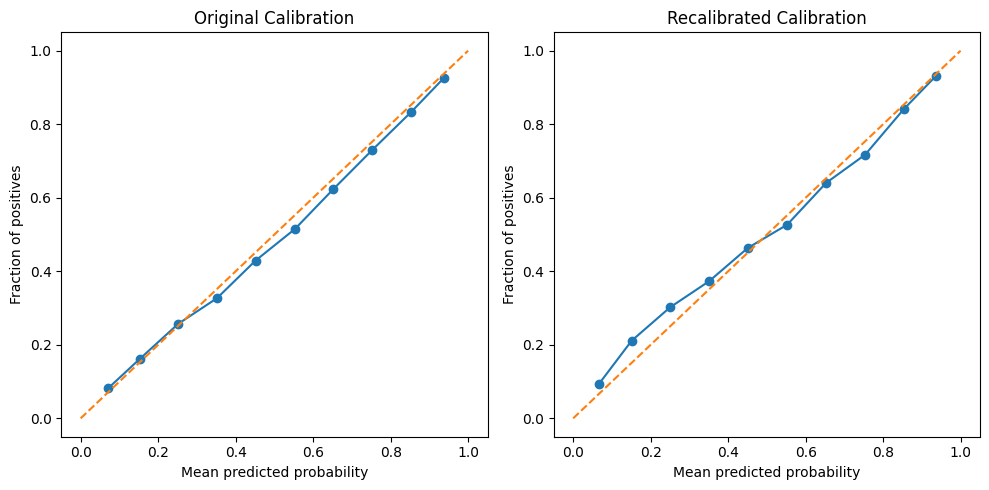

In [ ]:
from sklearn.calibration import calibration_curve  # Import calibration_curve

def plot_calibration_curve(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_calibration_curve(y_test_tensor, probs_ce)
plt.title('Original Calibration')

plt.subplot(1, 2, 2)
plot_calibration_curve(y_test_tensor, probs_mixed)
plt.title('Recalibrated Calibration')

plt.tight_layout()
plt.show()

In [ ]:
from KiTE.metrics import ELCE2
result_mixed_housing=ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,probs_mixed, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)
result_mmce_housing=ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,probs_mmce, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)
result_ce_hosuing=ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,probs_ce, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

In [ ]:
result_mixed_housing

(0.0006184533706967365,
 array([ 8.24597060e-05, -7.00747848e-06, -2.52517864e-05,  1.50502681e-04,
         4.47710992e-06, -5.61547888e-05, -3.66596276e-05,  2.24991217e-05,
         2.62704385e-05, -3.85366839e-05, -9.50194162e-05, -4.27564625e-05,
         3.30186494e-05, -5.26768764e-05, -8.62395292e-05,  2.15846435e-05,
         2.97847693e-05,  5.65771581e-05, -4.29141374e-05, -1.67781422e-05,
         4.95369071e-05, -2.15141496e-05, -4.01653301e-05, -4.75442299e-05,
        -3.44443003e-05,  1.79408384e-05,  4.40707986e-05, -1.19061782e-04,
         3.73794934e-05,  9.90989877e-05,  1.59928774e-04, -9.37489255e-06,
         2.98121648e-05,  2.93824073e-06,  5.62843739e-06,  2.39272323e-04,
         6.09139765e-05, -3.34523630e-05,  2.86402739e-06, -2.56489972e-05,
         1.82615063e-05, -5.41529428e-05,  7.07759987e-05, -2.60235101e-05,
        -2.18933688e-05,  7.17410453e-06, -2.50646982e-05, -1.51320686e-05,
         4.14858415e-05, -1.18068507e-05,  3.67224100e-05,  1.03

In [ ]:
result_mmce_housing

(0.0010492191658670613,
 array([ 3.67690390e-05, -1.22898219e-05,  2.68537723e-05, -7.39764744e-05,
        -3.58783165e-05, -1.03583487e-05,  4.66525764e-05,  1.59662414e-05,
        -4.36466907e-05,  2.16053326e-05,  2.55323665e-05, -3.79982848e-06,
        -7.48991459e-05, -7.37477909e-05,  1.38667264e-04, -9.29493454e-05,
         2.84314146e-05, -1.24332768e-04,  1.14805181e-04, -1.36263449e-05,
        -1.29903194e-05,  5.29356469e-05, -4.57098267e-05, -7.75978415e-05,
         6.56980957e-05,  2.21432369e-06,  5.50129404e-05,  2.52761540e-05,
        -6.26517080e-05, -1.67334027e-05,  1.19418988e-05,  1.26138583e-05,
         8.55340443e-05, -5.10521030e-05, -2.18167479e-05,  2.28151044e-05,
         2.93241998e-05, -1.95191824e-05, -9.70530398e-06, -4.65316751e-05,
        -2.41786046e-05, -7.53323822e-05, -2.17876788e-05,  2.79915561e-05,
         1.29394473e-04, -1.46558394e-05,  6.76223597e-05,  1.81077333e-05,
        -6.34806205e-05, -1.29613345e-05, -5.92520262e-05,  2.10

# Adult

In [ ]:
data = pd.read_csv('/Users/ritwikvashistha/Downloads/adult.csv')
#data=data.sample(frac=0.02,random_state=1)
# Convert categorical variables into one-hot encoding
categorical = ['workclass', 'education', 'marital-status', 'occupation',
               'relationship', 'race', 'gender', 'native-country', 'income']
for name in categorical:
    one_hot = pd.get_dummies(data[name], prefix=name)
    data = data.drop(name, axis=1)
    data = data.join(one_hot)



# Split data into X and y
y = data['income_<=50K']
X = data.drop(['income_<=50K','income_>50K'], axis=1)


# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test, condition_train, condition_test = train_test_split(X, y, data.index, test_size=0.25,random_state=1)

categorical_columns = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'gender', 'native-country']
# Drop one column from each set of dummy variables to avoid multicollinearity
for col in categorical_columns:
    dummy_cols = [c for c in X_train.columns if c.startswith(col)]
    X_train = X_train.drop(dummy_cols[-1], axis=1)
    X_test = X_test.drop(dummy_cols[-1], axis=1)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)

X_test_tensor = torch.FloatTensor(X_test_scaled)


y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# Train with standard cross-entropy loss
model_ce = LogisticRegressionNN(input_dim=100)
optimizer_ce = optim.Adam(model_ce.parameters(), lr=0.01)
train_model(model_ce, lambda x, y, z: nn.CrossEntropyLoss()(z, y), optimizer_ce)

Epoch 10, Loss: 0.1783
Epoch 20, Loss: 0.4776
Epoch 30, Loss: 0.6642
Epoch 40, Loss: 0.1472
Epoch 50, Loss: 0.1343
Epoch 60, Loss: 0.4799
Epoch 70, Loss: 0.2590
Epoch 80, Loss: 0.5255
Epoch 90, Loss: 0.2621
Epoch 100, Loss: 0.2345


In [ ]:
# Train with mixed loss (including kernel-based calibration)
model_mixed = LogisticRegressionNN(input_dim=100)
mixed_loss = ClassificationMixedLoss(
    loss_scalers={"nll": 1.0, "mmd": 0.7},
    operands={'x': "rbf", 'y': "rbf"},
    scalers={'x': 1.0, 'y': 1.0},
    bandwidths={'x': 25, 'y': 1}
)
optimizer_mixed = optim.Adam(model_mixed.parameters(), lr=0.01)
train_model(model_mixed, mixed_loss, optimizer_mixed)

Epoch 10, Loss: 0.3538
Epoch 20, Loss: 0.1948
Epoch 30, Loss: 0.3652
Epoch 40, Loss: 0.3206
Epoch 50, Loss: 0.6892
Epoch 60, Loss: 0.2853
Epoch 70, Loss: 0.7337
Epoch 80, Loss: 0.5055
Epoch 90, Loss: 0.3381
Epoch 100, Loss: 0.4247


In [ ]:
# Train with MMCEMixedLoss
model_mmce = LogisticRegressionNN(input_dim=100)
mmce_loss = MMCEMixedLoss(
    loss_scalers={"nll": 1.0, "mmce": 0.7}
)
optimizer_mmce = optim.Adam(model_mmce.parameters(), lr=0.01)
train_model(model_mmce, mmce_loss, optimizer_mmce)

Epoch 10, Loss: 0.4929
Epoch 20, Loss: 0.8235
Epoch 30, Loss: 0.5974
Epoch 40, Loss: 0.6649
Epoch 50, Loss: 0.5216
Epoch 60, Loss: 0.4536
Epoch 70, Loss: 0.4032
Epoch 80, Loss: 0.4650
Epoch 90, Loss: 0.5773
Epoch 100, Loss: 0.3888


In [ ]:
model_ce.eval()
with torch.no_grad():
  logits = model_ce(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_ce = probs.numpy()

model_mixed.eval()
with torch.no_grad():
  logits = model_mixed(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_mixed = probs.numpy()

model_mmce.eval()
with torch.no_grad():
  logits = model_mmce(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_mmce = probs.numpy()

In [ ]:
def expected_calibration_error(y_true, y_prob):
    prob_true, prob_pred  = calibration_curve(y_true, y_prob, n_bins=10)
    return (np.sum(np.abs(prob_true - prob_pred)) / len(prob_true))

# Evaluate both models
ece_ce= expected_calibration_error(y_test_tensor,probs_ce)
ece_mixed = expected_calibration_error(y_test_tensor,probs_mixed)
ece_mmce = expected_calibration_error(y_test_tensor,probs_mmce)

print(f"ECE (Cross-Entropy): {ece_ce:.4f}")
print(f"ECE (MMD Mixed Loss): {ece_mixed:.4f}")
print(f"ECE (MMCE Mixed Loss): {ece_mmce:.4f}")

ECE (Cross-Entropy): 0.0478
ECE (MMD Mixed Loss): 0.0360
ECE (MMCE Mixed Loss): 0.0680


In [ ]:
brier_ce = brier_score_loss(y_test, probs_ce)
brier_mixed = brier_score_loss(y_test, probs_mixed)
#brier_ecekde=brier_score_loss(y_test, probs_ecekde)
brier_mmce = brier_score_loss(y_test, probs_mmce)

print(f"Brier score (Cross-Entropy): {brier_ce:.4f}")
print(f"Brier score (MMD Mixed Loss): {brier_mixed:.4f}")
#print(f"Brier score (ECEKDE Mixed Loss): {brier_ecekde:.4f}")
print(f"Brier score (MMCE Mixed Loss): {brier_mmce:.4f}")


Brier score (Cross-Entropy): 0.1080
Brier score (MMD Mixed Loss): 0.1092
Brier score (MMCE Mixed Loss): 0.1145


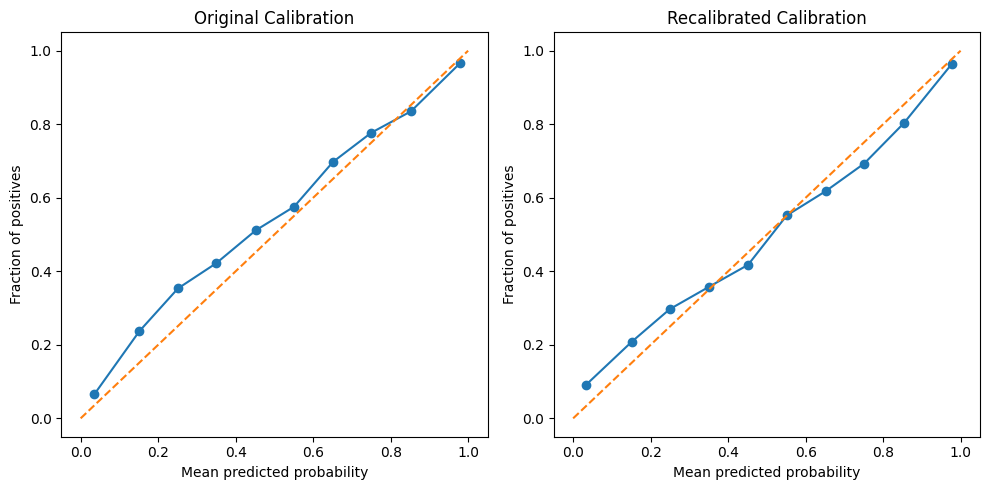

In [ ]:
from sklearn.calibration import calibration_curve  # Import calibration_curve

def plot_calibration_curve(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_calibration_curve(y_test_tensor, probs_ce)
plt.title('Original Calibration')

plt.subplot(1, 2, 2)
plot_calibration_curve(y_test_tensor, probs_mixed)
plt.title('Recalibrated Calibration')

plt.tight_layout()
plt.show()

In [ ]:
result_mixed_adult=ELCE2(X_test[['age','gender_Female']].values, y_test.values ,probs_mixed, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)
result_mmce_adult=ELCE2(X_test[['age','gender_Female']].values, y_test.values ,probs_mmce, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)
result_ce_adult=ELCE2(X_test[['age','gender_Female']].values, y_test.values ,probs_ce, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

In [ ]:
result_mixed_adult

(0.0015183926535610257,
 array([ 1.15426698e-04,  2.04909599e-04,  1.57248353e-04, -1.09183228e-04,
        -3.43478371e-04, -1.05584603e-04,  1.72699001e-04, -1.17873568e-05,
        -9.66017586e-05,  1.23904136e-04, -8.41458322e-05, -1.73849776e-04,
         1.37620893e-04,  1.02378877e-04, -1.69545237e-04,  1.22415136e-04,
         3.15305155e-04,  3.35995745e-04, -5.58782134e-05, -6.74159276e-05,
        -8.00473061e-05, -1.20235744e-04, -1.14432203e-04,  2.30068684e-04,
         1.80926553e-04, -7.82969890e-05, -2.01619982e-04,  3.42251679e-05,
        -3.02779668e-04,  2.12727237e-04,  9.77145260e-05,  4.27015414e-04,
        -1.16875663e-04,  1.01750212e-04,  1.97534081e-04,  1.80568495e-04,
         2.99290029e-04, -1.66089308e-04, -1.46723747e-04,  1.12891124e-04,
        -2.87113961e-04, -2.68650921e-04, -2.84603003e-04,  1.54385660e-04,
         8.49821487e-06, -2.33104448e-04,  2.15724737e-05,  3.40950840e-05,
        -1.05159703e-04, -9.44924398e-05, -2.08552555e-04, -2.99

In [ ]:
result_mmce_adult

(0.0014719580975761975,
 array([-1.03742429e-04, -2.68623541e-04, -1.33786067e-05, -2.56072985e-04,
         9.02405084e-05, -1.19115411e-04, -6.67975702e-05,  4.28845267e-05,
        -1.32669026e-04, -1.51035734e-04, -2.15312414e-04,  4.81312143e-05,
         2.41766853e-04, -6.29721020e-05,  1.68638729e-04, -2.40021594e-04,
         1.69476681e-04,  2.05822704e-04, -2.23460867e-05, -3.33613162e-04,
         1.09634905e-04, -2.49666860e-04, -1.53351161e-04, -1.20650253e-04,
        -2.72087118e-04, -4.56593282e-05, -8.77464372e-06, -3.64364617e-05,
        -1.87437343e-04, -1.03249464e-05, -3.69836004e-05,  2.90243900e-04,
         3.04839995e-04,  3.93921495e-04,  2.23900832e-04,  2.21272006e-05,
        -7.96698937e-07,  2.11152456e-04,  5.80176895e-05,  1.25625681e-04,
         1.72422071e-04,  4.27874196e-04,  3.51918808e-05,  9.85316338e-05,
         1.60215366e-04, -9.25869436e-05,  1.48347913e-04, -1.49446498e-04,
         2.95016327e-04, -1.79988863e-04,  4.70568119e-04,  2.06

In [ ]:
result_ce_adult

(0.0009193497822704706,
 array([ 1.13169937e-04,  1.26652612e-04, -2.56899493e-04, -1.44756702e-04,
         4.54433490e-05,  6.37750618e-05, -1.74713851e-04,  2.40541412e-05,
         3.92056084e-05, -3.11903451e-04,  3.31520591e-04, -1.08673039e-04,
        -1.80072291e-04, -2.30163958e-04,  2.20659054e-04, -1.55288709e-04,
        -1.18836365e-04,  6.40864428e-05,  1.78637876e-05, -1.16651350e-05,
        -1.10550314e-04, -1.48446140e-04, -6.06915332e-05,  4.40172303e-04,
        -8.21534044e-05, -1.11159901e-04, -3.21848482e-04,  4.54658939e-05,
        -1.39824219e-04,  8.70813433e-05, -1.01112787e-04, -4.22335440e-04,
        -2.98498714e-04, -7.08702028e-05,  3.04316203e-05,  5.58016733e-05,
         1.00333519e-04, -1.27227726e-04, -1.19490675e-04, -3.21205410e-04,
        -3.91862115e-04,  1.80875264e-04, -2.92186958e-05, -8.45102188e-05,
        -9.70522960e-05, -1.05194523e-04, -3.33541152e-05, -3.80607615e-05,
         3.43321301e-04, -1.10346303e-05, -7.70045720e-05, -3.60

# Heart Disease

In [ ]:
data = pd.read_csv('/Users/ritwikvashistha/Downloads/heart.csv')
# Convert categorical variables into one-hot encoding
categorical = ['Sex', 'ChestPainType' ,'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for name in categorical:
    one_hot = pd.get_dummies(data[name], prefix=name)
    data = data.drop(name, axis=1)
    data = data.join(one_hot)

# Split data into X and y
y = data['HeartDisease']
X = data.drop('HeartDisease', axis=1)


# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=31)

categorical_columns = ['Sex', 'ChestPainType' ,'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
# Drop one column from each set of dummy variables to avoid multicollinearity
for col in categorical_columns:
    dummy_cols = [c for c in X_train.columns if c.startswith(col)]
    X_train = X_train.drop(dummy_cols[-1], axis=1)
    X_test = X_test.drop(dummy_cols[-1], axis=1)


In [ ]:
data = pd.read_csv('/Users/ritwikvashistha/Downloads/heart.csv')

In [ ]:
data.shape

(918, 12)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)

X_test_tensor = torch.FloatTensor(X_test_scaled)


y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# Train with standard cross-entropy loss
model_ce = LogisticRegressionNN(input_dim=15)
optimizer_ce = optim.Adam(model_ce.parameters(), lr=0.01)
train_model(model_ce, lambda x, y, z: nn.CrossEntropyLoss()(z, y), optimizer_ce)

Epoch 10, Loss: 0.5034
Epoch 20, Loss: 0.2975
Epoch 30, Loss: 0.2107
Epoch 40, Loss: 0.3104
Epoch 50, Loss: 0.2064
Epoch 60, Loss: 0.2249
Epoch 70, Loss: 0.2661
Epoch 80, Loss: 0.3539
Epoch 90, Loss: 0.2683
Epoch 100, Loss: 0.3717


In [ ]:
# Train with mixed loss (including kernel-based calibration)
model_mixed = LogisticRegressionNN(input_dim=15)
mixed_loss = ClassificationMixedLoss(
    loss_scalers={"nll": 1.0, "mmd": 0.7},
    operands={'x': "rbf", 'y': "rbf"},
    scalers={'x': 1.0, 'y': 1.0},
    bandwidths={'x': 25, 'y': 1}
)
optimizer_mixed = optim.Adam(model_mixed.parameters(), lr=0.01)
train_model(model_mixed, mixed_loss, optimizer_mixed)

Epoch 10, Loss: 0.3191
Epoch 20, Loss: 0.2196
Epoch 30, Loss: 0.2538
Epoch 40, Loss: 0.3949
Epoch 50, Loss: 0.2606
Epoch 60, Loss: 0.2882
Epoch 70, Loss: 0.2210
Epoch 80, Loss: 0.6122
Epoch 90, Loss: 0.3601
Epoch 100, Loss: 0.4028


In [ ]:
# Train with MMCEMixedLoss
model_mmce = LogisticRegressionNN(input_dim=15)
mmce_loss = MMCEMixedLoss(
    loss_scalers={"nll": 1.0, "mmce": 0.7}
)
optimizer_mmce = optim.Adam(model_mmce.parameters(), lr=0.01)
train_model(model_mmce, mmce_loss, optimizer_mmce)

Epoch 10, Loss: 0.5172
Epoch 20, Loss: 0.4986
Epoch 30, Loss: 0.5477
Epoch 40, Loss: 0.5525
Epoch 50, Loss: 0.4897
Epoch 60, Loss: 0.4341
Epoch 70, Loss: 0.5413
Epoch 80, Loss: 0.4387
Epoch 90, Loss: 0.5406
Epoch 100, Loss: 0.4831


In [ ]:
model_ce.eval()
with torch.no_grad():
  logits = model_ce(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_ce = probs.numpy()

model_mixed.eval()
with torch.no_grad():
  logits = model_mixed(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_mixed = probs.numpy()

# model_ecekde.eval()
# with torch.no_grad():
#   logits = model_mixed(X_test_tensor)
#   probs = torch.softmax(logits, dim=1)[:, 1]
# probs_ecekde = probs.numpy()

model_mmce.eval()
with torch.no_grad():
  logits = model_mmce(X_test_tensor)
  probs = torch.softmax(logits, dim=1)[:, 1]
probs_mmce = probs.numpy()

In [ ]:
# Evaluate both models
ece_ce= expected_calibration_error(y_test_tensor,probs_ce)
ece_mixed = expected_calibration_error(y_test_tensor,probs_mixed)
ece_mmce = expected_calibration_error(y_test_tensor,probs_mmce)

print(f"ECE (Cross-Entropy): {ece_ce:.4f}")
print(f"ECE (MMD Mixed Loss): {ece_mixed:.4f}")
print(f"ECE (MMCE Mixed Loss): {ece_mmce:.4f}")

ECE (Cross-Entropy): 0.1014
ECE (MMD Mixed Loss): 0.0964
ECE (MMCE Mixed Loss): 0.0801


In [ ]:
brier_ce = brier_score_loss(y_test, probs_ce)
brier_mixed = brier_score_loss(y_test, probs_mixed)
brier_mmce = brier_score_loss(y_test, probs_mmce)

print(f"Brier score (Cross-Entropy): {brier_ce:.4f}")
print(f"Brier score (MMD Mixed Loss): {brier_mixed:.4f}")
print(f"Brier score (MMCE Mixed Loss): {brier_mmce:.4f}")

Brier score (Cross-Entropy): 0.1162
Brier score (MMD Mixed Loss): 0.1150
Brier score (MMCE Mixed Loss): 0.1130


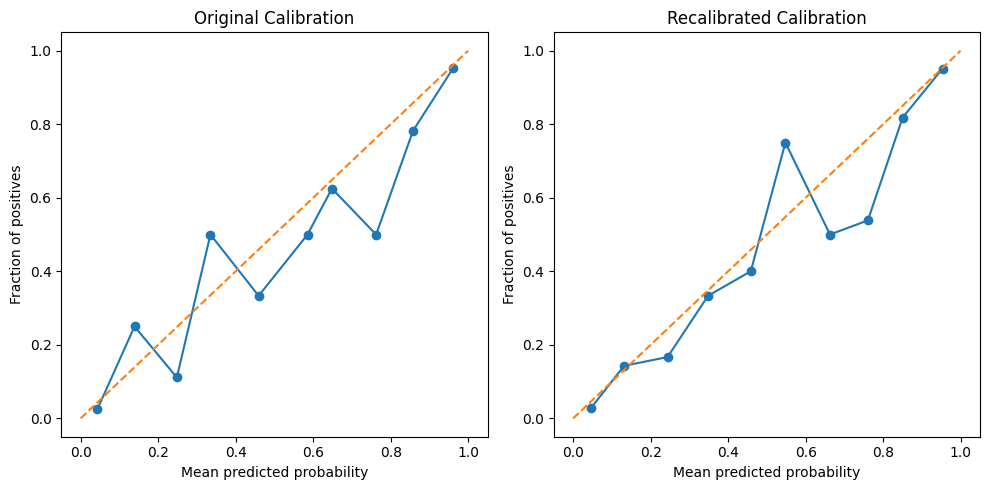

In [ ]:
from sklearn.calibration import calibration_curve  # Import calibration_curve

def plot_calibration_curve(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_calibration_curve(y_test_tensor, probs_ce)
plt.title('Original Calibration')

plt.subplot(1, 2, 2)
plot_calibration_curve(y_test_tensor, probs_mmce)
plt.title('Recalibrated Calibration')

plt.tight_layout()
plt.show()

In [ ]:
result_mixed_heart=ELCE2(X_test[['Age','Sex_F']].values, y_test.values ,probs_mixed, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)
result_mmce_heart=ELCE2(X_test[['Age','Sex_F']].values, y_test.values ,probs_mmce, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)
result_ce_heart=ELCE2(X_test[['Age','Sex_F']].values, y_test.values ,probs_ce, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

In [ ]:
result_mixed_heart

(0.0028263789845994823,
 array([ 1.33331281e-03,  1.19452025e-02, -2.02983651e-03, -9.25754162e-03,
         8.67881321e-03, -1.51780173e-03, -8.56865105e-04, -1.36028233e-03,
        -2.31532627e-03,  8.44976001e-03, -1.16621441e-03, -5.76661767e-04,
         9.42623352e-03, -1.16902929e-03, -2.20448427e-03, -6.60989513e-03,
         1.26092861e-02, -1.00851638e-04, -3.14128547e-03,  2.60961533e-03,
         4.42515168e-03,  7.77740533e-03,  7.75900814e-03,  3.90023210e-03,
        -9.13508488e-03, -7.63676254e-03, -1.03118182e-02, -9.02183335e-04,
         2.07883673e-03, -4.83126517e-03,  5.56891161e-03,  1.66713429e-03,
         2.61630918e-03, -1.08239707e-02,  4.95029266e-03, -6.10558758e-04,
        -5.34254490e-03, -1.29560036e-02, -1.08038458e-03, -4.71474642e-03,
        -2.74215898e-03, -3.31176326e-03,  1.97542706e-03, -3.02981357e-03,
         5.84565500e-04,  8.23264345e-03,  5.92594876e-04,  8.96063657e-04,
         2.66321842e-03,  4.20837396e-03,  1.64912916e-03, -2.01

In [ ]:
result_ce_heart

(0.0031567078102717654,
 array([-1.04446740e-02,  3.01578173e-03, -1.00387126e-03,  2.81710598e-03,
        -7.49300705e-04,  3.69124216e-03,  5.07575360e-03, -2.04889464e-04,
         3.99419210e-03,  1.02074563e-03,  7.39684825e-04, -8.84904073e-03,
         8.72374876e-05, -7.00756590e-05,  9.67748795e-04, -4.13927998e-03,
         3.33832397e-03, -2.28969157e-03,  4.14597427e-03,  9.80836502e-03,
        -1.14397563e-02,  9.19365994e-04,  5.46060181e-04,  3.76278138e-03,
         3.48084626e-03, -5.84991058e-03, -9.49584477e-03, -2.77582333e-03,
        -2.56844279e-03, -7.73248926e-03,  9.11331683e-03,  1.33914324e-02,
        -2.37894756e-03, -2.53660707e-03,  1.04829556e-02, -8.14932474e-03,
         1.38690063e-03,  6.78216286e-03, -2.60196798e-03,  3.99699644e-03,
        -1.15272256e-02,  2.18362977e-03,  7.47437070e-04, -7.73338282e-03,
        -2.59941476e-04, -3.23735411e-03, -1.03392578e-03,  2.60870122e-03,
        -5.42827735e-03,  3.10807417e-04,  5.48007300e-03,  8.14

In [ ]:
result_mmce_heart

(0.003851798698990523,
 array([-1.00896208e-02,  3.89986739e-03, -1.89447042e-03, -1.26000466e-03,
         3.07922143e-03, -7.52985540e-03, -8.72647599e-04,  4.52101020e-03,
        -1.44658331e-03,  6.54975767e-03, -9.58496995e-03,  6.23956241e-04,
         2.10445720e-03,  9.01086687e-03, -2.53632560e-03, -1.07817314e-02,
         7.04570803e-04, -3.84597710e-03,  1.27874993e-03,  1.37502562e-02,
        -3.35850882e-03, -1.46052868e-03,  1.54679002e-04, -1.32571804e-02,
         9.37671955e-03, -5.75166603e-03, -8.05105191e-03, -5.21126433e-03,
        -9.12213263e-03, -9.72607903e-04,  2.63691103e-03, -8.66303132e-04,
         7.62701432e-03,  4.06993395e-03,  5.41213893e-03, -9.40576131e-03,
         9.77427300e-03, -1.16619013e-03,  8.30530801e-03, -4.56934651e-04,
        -2.57188135e-03, -3.95603941e-03,  1.23469664e-02, -4.86075614e-03,
        -8.55525982e-03,  2.55167995e-03, -6.79313816e-03, -3.61779889e-03,
        -2.92666699e-03,  1.03739835e-02, -2.05552942e-03, -2.304